In [1]:
#You have to create one supervisor node
#Create one router function
#Create 3 more nodes
# 1)LLM Call
# 2)RAG Node
# 3)Web crawler(fetch the info in real time from internet)
#Create one more node after this for validation for generated output -->explore the validation part how to do that
#If validation going to be failed in that case go to the supervisor node and then supervisor node will again decide what needs to be called next
#Once the validation will pass then only generate the final output

In [2]:
#LLM Model
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

#Embedding
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

#Retriever
from langchain_community.document_loaders import DirectoryLoader, TextLoader
loader = DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)

documents = loader.load()
len(documents)

from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
split_doc = text_splitter.split_documents(documents)
#split_doc




d:\agenticBatch\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# vector store and retriever
from langchain_community.vectorstores import Chroma
vector = Chroma.from_documents(split_doc,embeddings)
retriever = vector.as_retriever(search_kwargs={"k":3})

In [4]:
from pydantic import BaseModel,Field

class TopicSelection(BaseModel):
    Topic:str=Field(description="selected topic either usa or india or not usa")
    Reasoning:str=Field(description="Reasoning behind selected topic")

from langchain_core.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelection)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic either usa or india or not usa", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind selected topic", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [5]:
#Creation of class for workflows
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage, HumanMessage
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

# Create an instance
state: AgentState = {"messages": []}

# Append a proper message object
state["messages"].append(HumanMessage(content="What are you doing?"))
state["messages"].append(HumanMessage(content="WHii"))
state["messages"].append(HumanMessage(content="What is GDP of USA?"))

In [6]:
#Supervisor node
from langchain_core.prompts import PromptTemplate
def function_1(state:AgentState):
    print(state)
    print("-->Supervisor-->")
    question = state["messages"][-1]
    print("-->1-->")
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,INDIA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    print("-->2-->")
    prompt = PromptTemplate(
        template =template,
        input_variables = ["question"],
        partial_variables = {"format_instructions":parser.get_format_instructions()}
    )
    print("-->3-->")
    chain = prompt | model | parser
    print("-->4-->")
    response = chain.invoke({"question":question})
    print("Parsed response", response)
    return {"messages": [response.Topic]}


In [7]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [8]:
#RAG node
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
def function_2(state:AgentState):
    print("-->RAG-->")
    question = state["messages"][0]
    template = """
     You are an assistant for question-answering tasks. Use the following pieces of retrieved
     context to answer the question. If you don't know the answer, just say that you don't know.
     Use three sentences maximum and keep the answer concise.\n
     Question: {question} \n Context: {context} \n Answer:
     """

    prompt = PromptTemplate(
        template =template,
        input_variables = ['context','question']
    )

    rag_chain = {"context":retriever | format_docs,"question":RunnablePassthrough()}| prompt | model | StrOutputParser()

    response = rag_chain.invoke(question)
    print("Response returned", response)
    return {"messages": [response]}

In [9]:
#LLM node
def function_3(state:AgentState):
    print("-->LLM-->")
    question = state["messages"][0]
    complete_query = "Answer the follow question with your knowledge of the real world. Following is the user question:"+question
    response = model.invoke(complete_query)
    print("Response returned", response.content)
    return {"messages": [response.content]}

In [10]:
# TravilySearch/Web crawler(fetch the info in real time from internet)
from langchain_community.tools import TavilySearchResults
import os
api_key = os.getenv("TAVILY_API_KEY")
tool = TavilySearchResults(tavily_api_key=api_key)
def function_4(state:AgentState):
    print("-->Tavily-->")
    question = state["messages"][0]
    response = tool.invoke(question)
    # Extract just the content from first result
    if response and isinstance(response, list):
        answer = response[0]["content"]
        print("results found:")
    else:
        print("No results found:")
        answer = "No results found."

    print("response:", answer)

    return {"messages": [answer]}

C:\Users\nupur\AppData\Local\Temp\ipykernel_34684\4141831165.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(tavily_api_key=api_key)


In [11]:
#res = function_4({"messages":["What is the weather in uas?"]})


In [12]:
def router(state:AgentState):
    print("-->Router-->")
    question = state["messages"][-1].lower()
    if "usa" in question:
        print("-->Router:RAG Call-->")
        return "RAG Call"
    elif "india" in question:
        print("-->Router:WebCrawling Call-->")
        return "WebCrawling Call"
    else:
        print("-->Router:LLM Call-->")
        return "LLM Call"

In [13]:
def validation(state:AgentState):
    print("-->validation-->")
    response = state["messages"][-1]
    if not response or len(response) < 10:
        print("❌ Validation failed")
        return {"is_valid": False}
    print("✅ Validation passed")
    return {"is_valid": True}

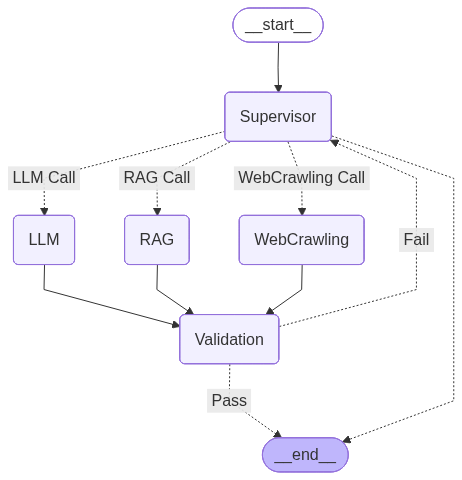

In [14]:
#Workflows
from langgraph.graph import StateGraph,END
workflow = StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("WebCrawling",function_4)
workflow.add_node("Validation",validation)
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM",
        "WebCrawling Call":"WebCrawling"
    }
)
# Conditional flow from Validation
workflow.add_conditional_edges(
    "Validation",
    lambda state: "Pass" if state.get("is_valid", True) else "Fail",  
    {
        "Pass": END,
        "Fail": "Supervisor"
    }
)
workflow.add_edge("RAG","Validation")
workflow.add_edge("LLM","Validation")
workflow.add_edge("WebCrawling","Validation")
workflow.add_edge("Validation",END)
app = workflow.compile()
app

In [15]:
state = {"messages": ["Hi"]}
app.invoke(state)

{'messages': ['Hi']}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='Not Related' Reasoning='The query "Hi" is a generic greeting and does not relate to the USA or INDIA.'
-->Router-->
-->Router:LLM Call-->
-->LLM-->
Response returned Hi!  How can I help you today?
-->validation-->
✅ Validation passed


{'messages': ['Hi', 'Not Related', 'Hi!  How can I help you today?']}

In [16]:
state = {"messages":["Can you tell me industrial growth of world's most poor economy?"]}
result= app.invoke(state)
result["messages"][-1]

{'messages': ["Can you tell me industrial growth of world's most poor economy?"]}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='Not Related' Reasoning="The query asks about the industrial growth of the world's poorest economy, which is a global topic not specific to the USA or India."
-->Router-->
-->Router:LLM Call-->
-->LLM-->
Response returned There's no single, universally agreed-upon metric for "world's most poor economy," as different organizations use different measures (GDP per capita, poverty rates, Human Development Index, etc.) and rankings fluctuate.  Furthermore, reliable industrial growth data for the poorest countries is often scarce or unreliable due to limited data collection infrastructure and economic volatility.

However, we can make some general observations:

* **Industrial growth in the poorest economies is typically low and often volatile.** These economies often rely heavily on agriculture and lack the infrastructure, capital, and skil

'There\'s no single, universally agreed-upon metric for "world\'s most poor economy," as different organizations use different measures (GDP per capita, poverty rates, Human Development Index, etc.) and rankings fluctuate.  Furthermore, reliable industrial growth data for the poorest countries is often scarce or unreliable due to limited data collection infrastructure and economic volatility.\n\nHowever, we can make some general observations:\n\n* **Industrial growth in the poorest economies is typically low and often volatile.** These economies often rely heavily on agriculture and lack the infrastructure, capital, and skilled labor needed for significant industrial development.  They may experience short bursts of growth tied to specific commodity exports (e.g., mining), but sustained, broad-based industrialization is rare.\n\n* **Challenges hinder industrial growth:** These challenges include:\n    * **Lack of infrastructure:** Poor transportation, energy, and communication networks

In [17]:
state = {"messages":["Can you tell me gdp of USA?"]}
result= app.invoke(state)

{'messages': ['Can you tell me gdp of USA?']}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'
-->Router-->
-->Router:RAG Call-->
-->RAG-->
Response returned The nominal GDP of the United States is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.
-->validation-->
✅ Validation passed


In [ ]:
#Validation flow where response of travily is manually changed to null
state = {"messages":["Can you tell me gdp of India?"]}
result= app.invoke(state)

{'messages': ['Can you tell me gdp of India?']}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='INDIA' Reasoning='The query explicitly asks for the GDP of India.'
-->Router-->
-->Router:WebCrawling Call-->
-->Tavily-->
results found:
response: $4.19 trillion (nominal; 2025 est.) ... $17.65 trillion (PPP; 2025 est.) GDP rank. 4th (nominal; 2025) · 3rd
-->validation-->
❌ Validation failed
{'messages': ['Can you tell me gdp of India?', 'INDIA']}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='INDIA' Reasoning='The user query explicitly mentions INDIA.'
-->Router-->
-->Router:WebCrawling Call-->
-->Tavily-->
results found:
response: $4.19 trillion (nominal; 2025 est.) ... $17.65 trillion (PPP; 2025 est.) GDP rank. 4th (nominal; 2025) · 3rd
-->validation-->
❌ Validation failed
{'messages': ['Can you tell me gdp of India?', 'INDIA', 'INDIA']}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='INDIA' Reasoning="The user quer

In [15]:
#Travily flow
state = {"messages":["Can you tell me gdp of India?"]}
result= app.invoke(state)

{'messages': ['Can you tell me gdp of India?']}
-->Supervisor-->
-->1-->
-->2-->
-->3-->
-->4-->
Parsed response Topic='INDIA' Reasoning='The query explicitly asks for the GDP of India.'
-->Router-->
-->Router:WebCrawling Call-->
-->Tavily-->
results found:
response: $4.19 trillion (nominal; 2025 est.) ... $17.65 trillion (PPP; 2025 est.) GDP rank. 4th (nominal; 2025) · 3rd
-->validation-->
✅ Validation passed
